## Homework 4: due 2022/05/09 23:59 (100%)

### - Tutorial : 

1. Training on MNIST: https://www.kaggle.com/code/juiyangchang/cnn-with-pytorch-0-995-accuracy
2. Torchvision transforms: https://pytorch.org/vision/stable/transforms.html
3. Pytorch learning rate scheduler: https://pytorch.org/docs/stable/optim.html
4. How to get learning rate: https://stackoverflow.com/questions/52660985/pytorch-how-to-get-learning-rate-during-training

### - After you go through the tutorials, you should be able to work on this assignment.

### - Please answer the following questions and work directly on this jupyter notebook.

### - Make sure the code can be run and show the result and figures properly.

### - Please write down your observation with markdown in this notebook briefly.



#### You will train a multi-class classfication model in this part. The data contains the images with three categories: cats, dogs and pandas. You can find the details of each column at https://www.kaggle.com/datasets/ashishsaxena2209/animal-image-datasetdog-cat-and-panda.

In [1]:
# Import necessory modules
%matplotlib inline
import os
import glob
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as tr
import torchvision.models as models
from torch.optim.lr_scheduler import MultiStepLR
import PIL.Image as Image
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm

In [2]:
# For reproduce the result
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

### 1. Define the model and dataset (30%)

#### 1.1 Please create a class **AnimalDataset** for loading the data, and a varibale ***transform*** for the preprocessing transformation should be created for later usage.  (15%)

In [3]:
#necessary package
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Define the model and dataset
class AnimalDataset(Dataset):
    def __init__(self, imgpath, transform=None):
        # directory of train/test/val and get cats dogs panda
        self.animalclass = os.listdir(imgpath) #['cats', 'dogs', 'panda']
        self.X = [] # image demonstration with pixel
        self.Y = [] # labels
        self.transform = transform  # use for data augmentation
        
        # i for count, img_class for 3 classes
        for(i, img_class) in enumerate(self.animalclass): 
            # directory of cat/dog/panda 
            img = os.path.join(imgpath, img_class) 
            image = glob.glob(os.path.join(img, '*.jpg')) 
            self.X.extend(image)
            self.Y.extend([i]*len(image))
        
        # X,Y array
        self.X = np.array(self.X)
        self.Y = np.array(self.Y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        imgPath = self.X[idx]
        x = Image.open(imgPath) # get the image
        if self.transform:
            x = self.transform(x)
        return x, self.Y[idx].astype(torch.LongTensor)

#### 1.2 Please create a class **CNN** as your network with the architecture below. (15%)
##### (Note. Please determine the output layer by the task)

| Block 1 | Block 2 |  Fully Connected Layer |
|:---:|:---:|:---:|
| 3x3 conv, 64 | 3x3 conv, 128 |  Linear, 512 |
| ReLU         | ReLU   |Dropout(p=0.5)  |
| 2x2 MaxPooling, downsampling factor 2       | 2x2 MaxPooling, downsampling factor 2   | ReLU  |
|          |    |Linear, 256  |
|          |    |Dropout(p=0.5)  |
|          |    |ReLU |

In [4]:
# create CNN network
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        # image shape is 32*32*3 (RGB 3 channels)
        # convolution layer
        self.convolution = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
            #nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            #nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            )
        
        # fully connected layer
        self.fc1 = nn.Sequential(
            nn.Linear(128 * 8 * 8, 512),
            #nn.BatchNorm1d(512),
            nn.Dropout(p = 0.5),
            nn.ReLU(inplace=True),
            nn.Linear(512, 256),
            #nn.BatchNorm1d(256),
            nn.Dropout(p = 0.5),
            nn.ReLU(inplace=True),
            )
        
        # last fully connected layer output should be same as classes
        self.fc2 = nn.Linear(256, 3)
        
    def forward(self, x):
        x = self.convolution(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        
        return x

# Instantiate a CNN model 
model = CNN()

### 2. Train the model (70%)

#### 2.1 Please load the train/validation/test data from ***./animals*** respectively and resize the image to 32x32. For the data preprocessing, please apply ***RandomHorizontalFlip(p=0.5)*** and ***RandomRotation((-10,10))*** as data augmentations. Also, scale all the value in the range between 0 and 1 and normalize with mean value ***(0.485,0.456,0.406)*** and standard deviation ***(0.229,0.224,0.225)*** for RGB channel respectively. At last, create the DataLoaders with batch size 32.(10%)
##### (Note. The mean and standard deviation is calculated from ImageNet dataset) 

In [5]:
#Define transformation
# train
train_tranforms = tr.Compose([
    tr.Resize(size=(32, 32)),
    tr.RandomHorizontalFlip(p=0.5),
    tr.RandomRotation((-10, 10)),
    # ToTensor: convert a PIL image to tensor in range [0,255] to a torch.Tensor(CHW) in the range [0.0,1.0]
    tr.ToTensor(), 
    tr.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# val/test
valtest_tranforms = tr.Compose([
    tr.Resize(size=(32, 32)),
    tr.ToTensor(),
    tr.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


# dataset path (train/test/val)
train_path = '../HW4-1/animals/train'
val_path = '../HW4-1/animals/val'
test_path = '../HW4-1/animals/test'

# batch size
batch_size = 32

# load data
train_dataset = AnimalDataset(train_path, transform=train_tranforms)
val_dataset = AnimalDataset(val_path, transform=valtest_tranforms)
test_dataset = AnimalDataset(test_path, transform=valtest_tranforms)
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

#### 2.2 Train the CNN model with the same hyperpameters below and do the validation every epoch. Choose the appropriate type of loss according to the task. Please record the learning rate, training/validation loss and training/validation accuracy every epoch. Also, save the model weights as ***model_without_scheduler.pth***(20%)


| | Learning rate | epochs | optimizer | weight decay | $\beta _1$|$\beta _2$|
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|***Hyperparameter***| 5e-3 | 100 | Adam | 1e-2 | 0.9 | 0.99 |

In [6]:
import time
from torch.autograd import Variable
def train(model, train_loader, val_loader, epochs, criterion, optimizer, device):
    since = time.time()
    
    best_Acc = 0
    Loss = []
    Acc = []
    ValLoss = []
    ValAcc = []
    Learning_rate = []


    for i in range(epochs):
        
        # setting
        startTime = time.time()
        train_Loss = 0
        correct_train = 0
        
        # train
        model.train()
        for data, label in tqdm(train_loader):
            # 1.Define variables (get the inputs)
            data, label = Variable(data.to(device)), Variable(label.to(device))
            # 2.Clear gradients
            optimizer.zero_grad()
            # 3.Forward propagation
            output = model(data)
            # 4.Calculate softmax and cross entropy loss
            loss = criterion(output, label) 
            # 5.Calculate gradients Back propagation
            loss.backward()
            # 6.Update parameters
            optimizer.step()
            # 7.extract the loss value
            train_Loss += loss.item()
            # 8.Get predictions from the maximum value
            predict = torch.max(output.data, 1)[1]
            # 9.Total correct predictions
            correct_train += (predict == label).float().sum()
        

        train_Loss = train_Loss / len(train_loader.dataset) 
        train_Acc = correct_train / len(train_loader.dataset)
        # record loss/acc for every epoch 
        Loss.append(train_Loss)
        Acc.append(train_Acc)
        # record learning rate for every epoch 
        Learning_rate.append(optimizer.param_groups[0]['lr'])


        # Validation
        with torch.no_grad():
            model.eval()
            val_Acc = 0
            val_Loss = 0
            correct_val = 0
            
            for data, label in val_loader:
                data, label = Variable(data.to(device)), Variable(label.to(device))
                output = model(data)
                loss = criterion(output, label)
                val_Loss += loss.item()
                predict = torch.max(output.data, 1)[1]
                correct_val += (predict == label).float().sum()

            val_Loss = val_Loss / len(val_loader.dataset)
            val_Acc = correct_val / len(val_loader.dataset)
            # record loss/acc for every epoch 
            ValLoss.append(val_Loss)
            ValAcc.append(val_Acc)
        
            print('Train Epoch: {}/{} Loss: {} Acc: {:.6f}% Val_Loss: {} Val_Acc: {:.6f}%'.format(i+1, epochs, train_Loss, train_Acc, val_Loss, val_Acc)) 
    
    # save the best model if it gain performance on validation set
    if val_Acc > best_Acc:
        torch.save(model.state_dict(), 'model_without_scheduler.pth')
        best_Acc = val_Acc
        
        print('model saved')
    
    return Loss, Acc, ValLoss, ValAcc, Learning_rate

In [7]:
# hyperparameters
# Define the loss function with Classification Cross-Entropy loss and an optimizer with Adam optimizer
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = optim.Adam(model.parameters(), lr=5e-3, betas=(0.9, 0.99),  weight_decay=1e-2)
epochs = 100
(Loss, Acc, ValLoss, ValAcc, Learning_rate) = train(model=model,
                                                    train_loader=train_loader,
                                                    val_loader=val_loader,
                                                    epochs=epochs,
                                                    device=device,
                                                    criterion=criterion,
                                                    optimizer=optimizer)

  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 1/100 Loss: 0.039063289165496826 Acc: 0.396667% Val_Loss: 0.03436775164057811 Val_Acc: 0.450000%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 2/100 Loss: 0.02798739708132214 Acc: 0.556111% Val_Loss: 0.026812137104570866 Val_Acc: 0.538542%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 3/100 Loss: 0.026591609716415405 Acc: 0.576667% Val_Loss: 0.023779266917457183 Val_Acc: 0.564583%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 4/100 Loss: 0.024839066565036774 Acc: 0.592222% Val_Loss: 0.026560003062089284 Val_Acc: 0.543750%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 5/100 Loss: 0.02497738344801797 Acc: 0.588889% Val_Loss: 0.02752187674244245 Val_Acc: 0.572917%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 6/100 Loss: 0.024193989998764463 Acc: 0.616667% Val_Loss: 0.02325155643435816 Val_Acc: 0.597917%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 7/100 Loss: 0.024307608869340684 Acc: 0.593889% Val_Loss: 0.022319861191014447 Val_Acc: 0.607292%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 8/100 Loss: 0.022828661186827554 Acc: 0.615556% Val_Loss: 0.022022146071928244 Val_Acc: 0.626042%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 9/100 Loss: 0.02378031975693173 Acc: 0.610000% Val_Loss: 0.022107739467173815 Val_Acc: 0.600000%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 10/100 Loss: 0.023625270823637644 Acc: 0.587778% Val_Loss: 0.023292598671590288 Val_Acc: 0.639583%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 11/100 Loss: 0.02271635029051039 Acc: 0.608889% Val_Loss: 0.02145980385442575 Val_Acc: 0.596875%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 12/100 Loss: 0.024585257007016074 Acc: 0.592222% Val_Loss: 0.0401134522020584 Val_Acc: 0.478125%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 13/100 Loss: 0.025109183854526942 Acc: 0.597778% Val_Loss: 0.027195331578453382 Val_Acc: 0.561458%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 14/100 Loss: 0.02318776145577431 Acc: 0.615556% Val_Loss: 0.021947846592714388 Val_Acc: 0.622917%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 15/100 Loss: 0.023495771123303307 Acc: 0.601667% Val_Loss: 0.021415113269661865 Val_Acc: 0.643750%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 16/100 Loss: 0.022719883190260994 Acc: 0.603333% Val_Loss: 0.02278184415772557 Val_Acc: 0.596875%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 17/100 Loss: 0.02226234280400806 Acc: 0.648889% Val_Loss: 0.02656361907720566 Val_Acc: 0.568750%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 18/100 Loss: 0.022788446313805052 Acc: 0.627778% Val_Loss: 0.024072188953869044 Val_Acc: 0.548958%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 19/100 Loss: 0.02479089836279551 Acc: 0.590000% Val_Loss: 0.02310681496746838 Val_Acc: 0.580208%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 20/100 Loss: 0.02263049089246326 Acc: 0.607778% Val_Loss: 0.020837874811453123 Val_Acc: 0.630208%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 21/100 Loss: 0.02235654887225893 Acc: 0.598333% Val_Loss: 0.02142654308117926 Val_Acc: 0.639583%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 22/100 Loss: 0.02279196408059862 Acc: 0.637222% Val_Loss: 0.026190293405670674 Val_Acc: 0.558333%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 23/100 Loss: 0.022910095155239105 Acc: 0.628333% Val_Loss: 0.02180095004538695 Val_Acc: 0.621875%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 24/100 Loss: 0.022770173036389882 Acc: 0.621667% Val_Loss: 0.021941893547773362 Val_Acc: 0.629167%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 25/100 Loss: 0.022796137630939482 Acc: 0.619444% Val_Loss: 0.03597056275854508 Val_Acc: 0.527083%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 26/100 Loss: 0.023329576849937438 Acc: 0.610556% Val_Loss: 0.021306630914720397 Val_Acc: 0.638542%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 27/100 Loss: 0.021835701018571855 Acc: 0.628889% Val_Loss: 0.020823794680957994 Val_Acc: 0.643750%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 28/100 Loss: 0.02331740066409111 Acc: 0.594444% Val_Loss: 0.021428980104004344 Val_Acc: 0.608333%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 29/100 Loss: 0.0223867913418346 Acc: 0.640556% Val_Loss: 0.021572371696432432 Val_Acc: 0.637500%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 30/100 Loss: 0.022560873213741513 Acc: 0.611111% Val_Loss: 0.024928251467645168 Val_Acc: 0.587500%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 31/100 Loss: 0.022863874187072118 Acc: 0.615556% Val_Loss: 0.021899097661177317 Val_Acc: 0.613542%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 32/100 Loss: 0.02162874432073699 Acc: 0.646667% Val_Loss: 0.021307019035642347 Val_Acc: 0.626042%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 33/100 Loss: 0.022415514638026556 Acc: 0.628333% Val_Loss: 0.021353543736040592 Val_Acc: 0.625000%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 34/100 Loss: 0.022322436372439067 Acc: 0.611667% Val_Loss: 0.021161102724727245 Val_Acc: 0.618750%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 35/100 Loss: 0.0219335409005483 Acc: 0.632222% Val_Loss: 0.02112983330152929 Val_Acc: 0.608333%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 36/100 Loss: 0.02230352246099048 Acc: 0.631111% Val_Loss: 0.022112012344102063 Val_Acc: 0.623958%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 37/100 Loss: 0.022558154712120693 Acc: 0.612778% Val_Loss: 0.020530707528814675 Val_Acc: 0.632292%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 38/100 Loss: 0.02255165179570516 Acc: 0.620556% Val_Loss: 0.02033874038606882 Val_Acc: 0.643750%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 39/100 Loss: 0.022232968045605553 Acc: 0.612778% Val_Loss: 0.020967359375208616 Val_Acc: 0.622917%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 40/100 Loss: 0.021817391564448674 Acc: 0.612222% Val_Loss: 0.020936929170663157 Val_Acc: 0.640625%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 41/100 Loss: 0.02293125765191184 Acc: 0.606111% Val_Loss: 0.020787681840981048 Val_Acc: 0.637500%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 42/100 Loss: 0.022351738065481186 Acc: 0.638333% Val_Loss: 0.021209358183356623 Val_Acc: 0.621875%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 43/100 Loss: 0.02304446746905645 Acc: 0.616667% Val_Loss: 0.02070999100493888 Val_Acc: 0.614583%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 44/100 Loss: 0.022214228924777774 Acc: 0.624444% Val_Loss: 0.021050877946739394 Val_Acc: 0.640625%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 45/100 Loss: 0.021672009378671645 Acc: 0.643889% Val_Loss: 0.020367550663650036 Val_Acc: 0.657292%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 46/100 Loss: 0.02113449000649982 Acc: 0.637778% Val_Loss: 0.021359957987442613 Val_Acc: 0.621875%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 47/100 Loss: 0.021717397272586824 Acc: 0.652222% Val_Loss: 0.021373330103233456 Val_Acc: 0.630208%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 48/100 Loss: 0.022796588540077208 Acc: 0.619444% Val_Loss: 0.02302844375371933 Val_Acc: 0.635417%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 49/100 Loss: 0.0226883461078008 Acc: 0.611667% Val_Loss: 0.02060934215163191 Val_Acc: 0.614583%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 50/100 Loss: 0.022428865449296103 Acc: 0.637778% Val_Loss: 0.02208733217169841 Val_Acc: 0.604167%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 51/100 Loss: 0.022405656079451244 Acc: 0.620000% Val_Loss: 0.022287213895469903 Val_Acc: 0.610417%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 52/100 Loss: 0.02198487025168207 Acc: 0.621667% Val_Loss: 0.02000354053452611 Val_Acc: 0.646875%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 53/100 Loss: 0.02128009115656217 Acc: 0.637778% Val_Loss: 0.04896302554698195 Val_Acc: 0.394792%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 54/100 Loss: 0.022121030324035222 Acc: 0.611667% Val_Loss: 0.022373603160182633 Val_Acc: 0.615625%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 55/100 Loss: 0.02270867456992467 Acc: 0.594444% Val_Loss: 0.02101461177226156 Val_Acc: 0.620833%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 56/100 Loss: 0.02143993929028511 Acc: 0.616111% Val_Loss: 0.028809035507341225 Val_Acc: 0.557292%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 57/100 Loss: 0.021826777855555216 Acc: 0.643889% Val_Loss: 0.02019246850783626 Val_Acc: 0.643750%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 58/100 Loss: 0.021443346391121547 Acc: 0.646667% Val_Loss: 0.021791768291344247 Val_Acc: 0.613542%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 59/100 Loss: 0.022372267246246337 Acc: 0.638889% Val_Loss: 0.022065638455872734 Val_Acc: 0.598958%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 60/100 Loss: 0.022359832459025914 Acc: 0.613333% Val_Loss: 0.020887343880409994 Val_Acc: 0.632292%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 61/100 Loss: 0.02202125996351242 Acc: 0.611111% Val_Loss: 0.021458067333636185 Val_Acc: 0.636458%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 62/100 Loss: 0.022625656525293986 Acc: 0.636111% Val_Loss: 0.021232943221305808 Val_Acc: 0.629167%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 63/100 Loss: 0.022669524484210543 Acc: 0.615556% Val_Loss: 0.021195423727234205 Val_Acc: 0.633333%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 64/100 Loss: 0.022920900616380902 Acc: 0.615000% Val_Loss: 0.023940667665253084 Val_Acc: 0.577083%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 65/100 Loss: 0.023192552046643364 Acc: 0.606111% Val_Loss: 0.020666723993296426 Val_Acc: 0.637500%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 66/100 Loss: 0.02171847340133455 Acc: 0.637222% Val_Loss: 0.023135298036504538 Val_Acc: 0.594792%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 67/100 Loss: 0.021559240602784687 Acc: 0.619444% Val_Loss: 0.021189249970484526 Val_Acc: 0.625000%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 68/100 Loss: 0.022211473186810812 Acc: 0.638889% Val_Loss: 0.020897196605801582 Val_Acc: 0.631250%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 69/100 Loss: 0.02136863804525799 Acc: 0.640000% Val_Loss: 0.020055484073236585 Val_Acc: 0.648958%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 70/100 Loss: 0.021674431165059408 Acc: 0.643333% Val_Loss: 0.020845726411789656 Val_Acc: 0.642708%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 71/100 Loss: 0.0220497574739986 Acc: 0.619444% Val_Loss: 0.020680100268994767 Val_Acc: 0.653125%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 72/100 Loss: 0.022307730515797933 Acc: 0.631667% Val_Loss: 0.02102961509178082 Val_Acc: 0.643750%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 73/100 Loss: 0.022276001738177405 Acc: 0.631667% Val_Loss: 0.020449588152890403 Val_Acc: 0.675000%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 74/100 Loss: 0.024291036675373714 Acc: 0.623333% Val_Loss: 0.021412218579401572 Val_Acc: 0.615625%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 75/100 Loss: 0.021915652139319314 Acc: 0.606667% Val_Loss: 0.021411105462660392 Val_Acc: 0.644792%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 76/100 Loss: 0.021253221150901582 Acc: 0.652778% Val_Loss: 0.020196377392858268 Val_Acc: 0.650000%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 77/100 Loss: 0.022351446317301855 Acc: 0.617778% Val_Loss: 0.021064941305667162 Val_Acc: 0.645833%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 78/100 Loss: 0.022777548962169224 Acc: 0.614444% Val_Loss: 0.0216706366588672 Val_Acc: 0.604167%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 79/100 Loss: 0.02200083883272277 Acc: 0.640556% Val_Loss: 0.021446325785169997 Val_Acc: 0.632292%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 80/100 Loss: 0.022491323550542196 Acc: 0.628333% Val_Loss: 0.029235361330211162 Val_Acc: 0.526042%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 81/100 Loss: 0.021933087905248005 Acc: 0.643333% Val_Loss: 0.019808225302646556 Val_Acc: 0.640625%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 82/100 Loss: 0.021360874705844454 Acc: 0.642222% Val_Loss: 0.020584311856267353 Val_Acc: 0.639583%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 83/100 Loss: 0.021378736976120208 Acc: 0.626111% Val_Loss: 0.020346645421038072 Val_Acc: 0.654167%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 84/100 Loss: 0.021254957053396438 Acc: 0.661667% Val_Loss: 0.01995924722868949 Val_Acc: 0.656250%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 85/100 Loss: 0.021367511567142276 Acc: 0.639444% Val_Loss: 0.019831055014704665 Val_Acc: 0.662500%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 86/100 Loss: 0.02161782991555002 Acc: 0.640556% Val_Loss: 0.02039297982895126 Val_Acc: 0.616667%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 87/100 Loss: 0.021628313610951105 Acc: 0.632778% Val_Loss: 0.0986581647923837 Val_Acc: 0.346875%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 88/100 Loss: 0.02476708796289232 Acc: 0.613333% Val_Loss: 0.020679283274027207 Val_Acc: 0.661458%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 89/100 Loss: 0.02203429808219274 Acc: 0.618889% Val_Loss: 0.025786760076880456 Val_Acc: 0.605208%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 90/100 Loss: 0.023056932124826644 Acc: 0.612222% Val_Loss: 0.021573063754476606 Val_Acc: 0.620833%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 91/100 Loss: 0.021874664293395147 Acc: 0.622222% Val_Loss: 0.020620307279750706 Val_Acc: 0.656250%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 92/100 Loss: 0.02145357198185391 Acc: 0.646667% Val_Loss: 0.019763562874868513 Val_Acc: 0.671875%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 93/100 Loss: 0.021292700933085548 Acc: 0.658889% Val_Loss: 0.021414263593032955 Val_Acc: 0.663542%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 94/100 Loss: 0.021985062625673082 Acc: 0.648889% Val_Loss: 0.01974030692751209 Val_Acc: 0.681250%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 95/100 Loss: 0.020831383052799437 Acc: 0.665556% Val_Loss: 0.020641542955612144 Val_Acc: 0.651042%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 96/100 Loss: 0.02164654630753729 Acc: 0.643889% Val_Loss: 0.021256642641189198 Val_Acc: 0.627083%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 97/100 Loss: 0.021527390662166808 Acc: 0.643333% Val_Loss: 0.02002022328476111 Val_Acc: 0.646875%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 98/100 Loss: 0.021465213745832445 Acc: 0.635000% Val_Loss: 0.024356562333802383 Val_Acc: 0.634375%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 99/100 Loss: 0.021799092574252023 Acc: 0.626111% Val_Loss: 0.022821681449810664 Val_Acc: 0.609375%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 100/100 Loss: 0.02119896747999721 Acc: 0.652778% Val_Loss: 0.02110852881645163 Val_Acc: 0.635417%
model saved


#### 2.3 Please draw the plot the learning rate, training/validation loss and training/validation accuracy and write down the observation. (10%)
##### (Example figure)
![image.png](https://github.com/tingyan08/Deep-Learning-and-Computer-Vision/blob/main/HW4/img/curve1.png?raw=true)

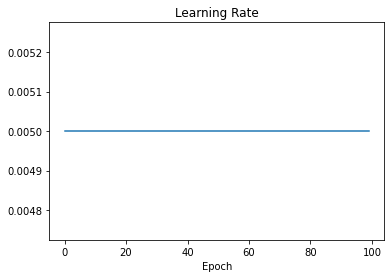

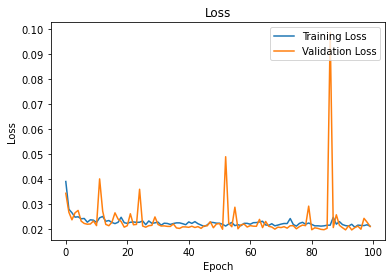

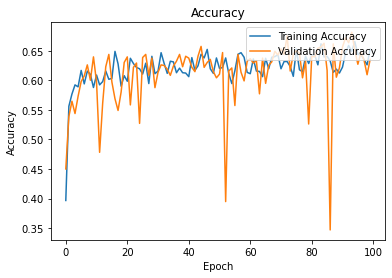

In [8]:
# visualization
# Learning Rate
plt.plot(range(epochs), Learning_rate)
plt.title('Learning Rate')
plt.xlabel('Epoch')
plt.show()
# Loss
plt.plot(range(epochs), Loss, label='Training Loss')
plt.plot(range(epochs), ValLoss, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc = 'upper right')
plt.show()
# Accuracy
plt.plot(range(epochs), Acc, label='Training Accuracy')
plt.plot(range(epochs),  ValAcc, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc = 'upper right')
plt.show()

#### 2.4 Please retrain model with learning rate decay with decreasing factor 0.1 at 20 epoch and 60 epoch. The other parameters are as same as last question. Also, redraw the learning rate, accuracy and loss curves and save the weights as ***model_with_scheduler.pth***. (10%)
##### (Example figure)
![image.png](https://github.com/tingyan08/Deep-Learning-and-Computer-Vision/blob/main/HW4/img/curve2.png?raw=true)

In [9]:
import time
from torch.autograd import Variable
def train(model, train_loader, val_loader, epochs, criterion, optimizer, device, scheduler):
    since = time.time()
    
    best_Acc = 0
    Loss = []
    Acc = []
    ValLoss = []
    ValAcc = []
    Learning_rate = []

    for i in range(epochs):
        
        # setting
        startTime = time.time()
        train_Loss = 0
        correct_train = 0
        
        # train
        model.train()
        for data, label in tqdm(train_loader):
            # 1.Define variables (get the inputs)
            data, label = Variable(data.to(device)), Variable(label.to(device))
            # 2.Clear gradients
            optimizer.zero_grad()
            # 3.Forward propagation
            output = model(data)
            # 4.Calculate softmax and cross entropy loss
            loss = criterion(output, label) 
            # 5.Calculate gradients Back propagation
            loss.backward()
            # 6.Update parameters
            optimizer.step() 
            # 7.extract the loss value
            train_Loss += loss.item()
            # 8.Get predictions from the maximum value
            predict = torch.max(output.data, 1)[1]
            # 9.Total correct predictions
            correct_train += (predict == label).float().sum()
        
        scheduler.step()
      

        train_Loss = train_Loss / len(train_loader.dataset) 
        train_Acc = correct_train / len(train_loader.dataset)
        # record loss/acc for every epoch 
        Loss.append(train_Loss)
        Acc.append(train_Acc)
        # record learning rate for every epoch 
        Learning_rate.append(scheduler.get_last_lr()[0])
 

        # Validation
        with torch.no_grad():
            model.eval()
            val_Acc = 0
            val_Loss = 0
            correct_val = 0
            
            for data, label in val_loader:
                data, label = Variable(data.to(device)), Variable(label.to(device))
                output = model(data)
                loss = criterion(output, label)
                val_Loss += loss.item()
                predict = torch.max(output.data, 1)[1]
                correct_val += (predict == label).float().sum()

            val_Loss = val_Loss / len(val_loader.dataset)
            val_Acc = correct_val / len(val_loader.dataset)
            # record loss/acc for every epoch 
            ValLoss.append(val_Loss)
            ValAcc.append(val_Acc)
        
            print('Train Epoch: {}/{} Loss: {} Acc: {:.6f}% Val_Loss: {} Val_Acc: {:.6f}%'.format(i+1, epochs, train_Loss, train_Acc, val_Loss, val_Acc)) 
    
    # save the best model if it gain performance on validation set
    if val_Acc > best_Acc:
        torch.save(model.state_dict(), 'model_with_scheduler.pth')
        best_Acc = val_Acc
        
        print('model saved')
    
    return Loss, Acc, ValLoss, ValAcc, Learning_rate

In [10]:
# Reload the data 

optimizer = optim.Adam(model.parameters(), lr=5e-3, betas=(0.9, 0.99),  weight_decay=1e-2)
scheduler = MultiStepLR(optimizer, milestones=[20,60], gamma=0.1)
(Loss_model2, Acc_model2, ValLoss_model2, ValAcc_model2, Learning_rate_model2) = train(model=model,
                                                                                       train_loader=train_loader,
                                                                                       val_loader=val_loader,
                                                                                       epochs=epochs,
                                                                                       device=device,
                                                                                       criterion=criterion,
                                                                                       optimizer=optimizer,
                                                                                       scheduler=scheduler)

  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 1/100 Loss: 0.02201208382844925 Acc: 0.632778% Val_Loss: 0.022360828099772335 Val_Acc: 0.615625%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 2/100 Loss: 0.022317168828513888 Acc: 0.641111% Val_Loss: 0.03208258599042892 Val_Acc: 0.532292%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 3/100 Loss: 0.022705994612640806 Acc: 0.638889% Val_Loss: 0.020416742206240693 Val_Acc: 0.669792%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 4/100 Loss: 0.021029445264074537 Acc: 0.648889% Val_Loss: 0.01988043882884085 Val_Acc: 0.677083%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 5/100 Loss: 0.020157329738140106 Acc: 0.662222% Val_Loss: 0.07504031867931645 Val_Acc: 0.382292%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 6/100 Loss: 0.023233412272400326 Acc: 0.627778% Val_Loss: 0.02201060641867419 Val_Acc: 0.597917%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 7/100 Loss: 0.021098606462279956 Acc: 0.661667% Val_Loss: 0.02144513468568524 Val_Acc: 0.627083%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 8/100 Loss: 0.021514238599273892 Acc: 0.661111% Val_Loss: 0.023489382800956568 Val_Acc: 0.620833%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 9/100 Loss: 0.02152025663190418 Acc: 0.637778% Val_Loss: 0.022836492264953753 Val_Acc: 0.636458%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 10/100 Loss: 0.022039605130751927 Acc: 0.624444% Val_Loss: 0.021814514727642138 Val_Acc: 0.609375%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 11/100 Loss: 0.02124536476201481 Acc: 0.648333% Val_Loss: 0.0239303812966682 Val_Acc: 0.617708%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 12/100 Loss: 0.0209167936609851 Acc: 0.649444% Val_Loss: 0.022464633259611826 Val_Acc: 0.647917%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 13/100 Loss: 0.021358110441101922 Acc: 0.664444% Val_Loss: 0.020633911962310472 Val_Acc: 0.670833%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 14/100 Loss: 0.021381157802210914 Acc: 0.682778% Val_Loss: 0.021255178765083354 Val_Acc: 0.623958%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 15/100 Loss: 0.021383327262269127 Acc: 0.653889% Val_Loss: 0.020067530187467732 Val_Acc: 0.698958%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 16/100 Loss: 0.02134175562196308 Acc: 0.665000% Val_Loss: 0.020671106564501922 Val_Acc: 0.672917%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 17/100 Loss: 0.021602486156755023 Acc: 0.649444% Val_Loss: 0.019811797002330423 Val_Acc: 0.667708%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 18/100 Loss: 0.021704017668962478 Acc: 0.656667% Val_Loss: 0.02145382339755694 Val_Acc: 0.655208%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 19/100 Loss: 0.02183335545990202 Acc: 0.667222% Val_Loss: 0.022636584056696545 Val_Acc: 0.635417%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 20/100 Loss: 0.022868258323934344 Acc: 0.637222% Val_Loss: 0.021218699278930823 Val_Acc: 0.620833%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 21/100 Loss: 0.021124984688229032 Acc: 0.641667% Val_Loss: 0.020388717677754662 Val_Acc: 0.651042%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 22/100 Loss: 0.020104821556144292 Acc: 0.678889% Val_Loss: 0.019745178047257166 Val_Acc: 0.677083%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 23/100 Loss: 0.019886758112245134 Acc: 0.682778% Val_Loss: 0.019719906772176426 Val_Acc: 0.655208%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 24/100 Loss: 0.019408454464541543 Acc: 0.703889% Val_Loss: 0.019335394694159427 Val_Acc: 0.677083%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 25/100 Loss: 0.018863119085629782 Acc: 0.701111% Val_Loss: 0.018895163324971993 Val_Acc: 0.695833%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 26/100 Loss: 0.018960086868868933 Acc: 0.683333% Val_Loss: 0.018730701537181933 Val_Acc: 0.698958%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 27/100 Loss: 0.01851609875758489 Acc: 0.706667% Val_Loss: 0.018547795123110215 Val_Acc: 0.698958%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 28/100 Loss: 0.018099494410885705 Acc: 0.712778% Val_Loss: 0.018412708258256315 Val_Acc: 0.709375%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 29/100 Loss: 0.01786932698554463 Acc: 0.735556% Val_Loss: 0.018343697224433225 Val_Acc: 0.701042%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 30/100 Loss: 0.017888828052414787 Acc: 0.733333% Val_Loss: 0.01864472491045793 Val_Acc: 0.693750%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 31/100 Loss: 0.017980229324764674 Acc: 0.726111% Val_Loss: 0.018700578079248468 Val_Acc: 0.693750%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 32/100 Loss: 0.017852552632490793 Acc: 0.741111% Val_Loss: 0.018441164245208103 Val_Acc: 0.710417%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 33/100 Loss: 0.017486635363764234 Acc: 0.735556% Val_Loss: 0.018307880917564034 Val_Acc: 0.708333%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 34/100 Loss: 0.01693215944700771 Acc: 0.737222% Val_Loss: 0.01826358149604251 Val_Acc: 0.711458%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 35/100 Loss: 0.01704852675398191 Acc: 0.738889% Val_Loss: 0.018084008417402705 Val_Acc: 0.714583%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 36/100 Loss: 0.01707633410890897 Acc: 0.751667% Val_Loss: 0.018426070051888625 Val_Acc: 0.703125%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 37/100 Loss: 0.017077490074767006 Acc: 0.750556% Val_Loss: 0.01798197431489825 Val_Acc: 0.708333%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 38/100 Loss: 0.017163632603155243 Acc: 0.747778% Val_Loss: 0.018127794051542877 Val_Acc: 0.713542%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 39/100 Loss: 0.01667619776394632 Acc: 0.747222% Val_Loss: 0.017878993522996704 Val_Acc: 0.715625%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 40/100 Loss: 0.017166896644565794 Acc: 0.751667% Val_Loss: 0.017876952746883036 Val_Acc: 0.715625%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 41/100 Loss: 0.016781772822141647 Acc: 0.746111% Val_Loss: 0.01806280428233246 Val_Acc: 0.718750%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 42/100 Loss: 0.017024723291397096 Acc: 0.750556% Val_Loss: 0.018048498081043363 Val_Acc: 0.720833%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 43/100 Loss: 0.01614284192522367 Acc: 0.762778% Val_Loss: 0.018104108050465584 Val_Acc: 0.728125%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 44/100 Loss: 0.016292036374409992 Acc: 0.775000% Val_Loss: 0.01807844436261803 Val_Acc: 0.719792%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 45/100 Loss: 0.016451302121082943 Acc: 0.750000% Val_Loss: 0.01781758953972409 Val_Acc: 0.731250%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 46/100 Loss: 0.0164324841565556 Acc: 0.762778% Val_Loss: 0.017902315493362644 Val_Acc: 0.727083%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 47/100 Loss: 0.01623676316605674 Acc: 0.760556% Val_Loss: 0.017784541783233482 Val_Acc: 0.723958%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 48/100 Loss: 0.01644734467069308 Acc: 0.760556% Val_Loss: 0.017836106816927592 Val_Acc: 0.722917%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 49/100 Loss: 0.016063235037856633 Acc: 0.765556% Val_Loss: 0.017767516088982423 Val_Acc: 0.716667%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 50/100 Loss: 0.016188651356432174 Acc: 0.768333% Val_Loss: 0.01839732046549519 Val_Acc: 0.720833%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 51/100 Loss: 0.01617129104004966 Acc: 0.770556% Val_Loss: 0.018204841669648884 Val_Acc: 0.711458%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 52/100 Loss: 0.015848625815576976 Acc: 0.770000% Val_Loss: 0.017747957973430553 Val_Acc: 0.715625%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 53/100 Loss: 0.016288105497757593 Acc: 0.769444% Val_Loss: 0.01768798124200354 Val_Acc: 0.725000%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 54/100 Loss: 0.01590178628762563 Acc: 0.772778% Val_Loss: 0.017789453143874805 Val_Acc: 0.721875%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 55/100 Loss: 0.0154153208517366 Acc: 0.786111% Val_Loss: 0.017773990953962007 Val_Acc: 0.733333%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 56/100 Loss: 0.015515579217010075 Acc: 0.782778% Val_Loss: 0.017667273866633575 Val_Acc: 0.732292%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 57/100 Loss: 0.014958853572607041 Acc: 0.784444% Val_Loss: 0.01746110073290765 Val_Acc: 0.729167%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 58/100 Loss: 0.015355362056030167 Acc: 0.783333% Val_Loss: 0.017498923217256865 Val_Acc: 0.728125%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 59/100 Loss: 0.01501970402068562 Acc: 0.792778% Val_Loss: 0.017622279243854184 Val_Acc: 0.739583%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 60/100 Loss: 0.015487540033128527 Acc: 0.788333% Val_Loss: 0.01764156248730918 Val_Acc: 0.731250%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 61/100 Loss: 0.014714739819367727 Acc: 0.785556% Val_Loss: 0.017336541227996348 Val_Acc: 0.734375%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 62/100 Loss: 0.014338845014572143 Acc: 0.807222% Val_Loss: 0.017323664335223535 Val_Acc: 0.732292%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 63/100 Loss: 0.014108358555369908 Acc: 0.804444% Val_Loss: 0.01737616260846456 Val_Acc: 0.738542%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 64/100 Loss: 0.014065730878048473 Acc: 0.813889% Val_Loss: 0.017417858021023372 Val_Acc: 0.729167%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 65/100 Loss: 0.013636679864592022 Acc: 0.805556% Val_Loss: 0.017419760573344927 Val_Acc: 0.734375%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 66/100 Loss: 0.014635124223099814 Acc: 0.806111% Val_Loss: 0.017424756870605053 Val_Acc: 0.735417%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 67/100 Loss: 0.01370403735174073 Acc: 0.811111% Val_Loss: 0.017436917987652123 Val_Acc: 0.737500%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 68/100 Loss: 0.013719221204519272 Acc: 0.815000% Val_Loss: 0.017475895366321006 Val_Acc: 0.729167%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 69/100 Loss: 0.014045932657188839 Acc: 0.802778% Val_Loss: 0.017425213661044835 Val_Acc: 0.732292%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 70/100 Loss: 0.014183227121829987 Acc: 0.808333% Val_Loss: 0.017367743809397023 Val_Acc: 0.736458%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 71/100 Loss: 0.013733701109886169 Acc: 0.808889% Val_Loss: 0.017454858520068228 Val_Acc: 0.730208%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 72/100 Loss: 0.014002734571695328 Acc: 0.810000% Val_Loss: 0.017380292426484326 Val_Acc: 0.736458%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 73/100 Loss: 0.014068136827813254 Acc: 0.815556% Val_Loss: 0.01742268174421042 Val_Acc: 0.737500%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 74/100 Loss: 0.013628101415104336 Acc: 0.812222% Val_Loss: 0.017392831295728682 Val_Acc: 0.737500%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 75/100 Loss: 0.01360414390762647 Acc: 0.811111% Val_Loss: 0.017468703685638805 Val_Acc: 0.736458%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 76/100 Loss: 0.013954897912012206 Acc: 0.808333% Val_Loss: 0.01750348419106255 Val_Acc: 0.737500%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 77/100 Loss: 0.013662292526827918 Acc: 0.823333% Val_Loss: 0.01748136499275764 Val_Acc: 0.739583%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 78/100 Loss: 0.013335339882307583 Acc: 0.815556% Val_Loss: 0.017434618071032068 Val_Acc: 0.739583%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 79/100 Loss: 0.013458216951953041 Acc: 0.813333% Val_Loss: 0.0174591599808385 Val_Acc: 0.736458%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 80/100 Loss: 0.01380623287624783 Acc: 0.815000% Val_Loss: 0.01747878217914452 Val_Acc: 0.731250%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 81/100 Loss: 0.01344183830751313 Acc: 0.807222% Val_Loss: 0.017478033783845603 Val_Acc: 0.730208%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 82/100 Loss: 0.01349829567803277 Acc: 0.818333% Val_Loss: 0.017448260627376536 Val_Acc: 0.735417%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 83/100 Loss: 0.013251882824632856 Acc: 0.830556% Val_Loss: 0.017438343532073002 Val_Acc: 0.735417%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 84/100 Loss: 0.013181768068008953 Acc: 0.812222% Val_Loss: 0.017425473655263583 Val_Acc: 0.732292%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 85/100 Loss: 0.013437525464428796 Acc: 0.819444% Val_Loss: 0.017451549274846913 Val_Acc: 0.733333%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 86/100 Loss: 0.013512230589985847 Acc: 0.815000% Val_Loss: 0.01740591450749586 Val_Acc: 0.735417%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 87/100 Loss: 0.013350605302386813 Acc: 0.807778% Val_Loss: 0.017465571609015264 Val_Acc: 0.737500%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 88/100 Loss: 0.013105089871419801 Acc: 0.820556% Val_Loss: 0.017355825317402682 Val_Acc: 0.738542%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 89/100 Loss: 0.013075193944904539 Acc: 0.828333% Val_Loss: 0.017446390880892674 Val_Acc: 0.735417%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 90/100 Loss: 0.013213639830549557 Acc: 0.825556% Val_Loss: 0.017375843646004797 Val_Acc: 0.736458%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 91/100 Loss: 0.013248779359791013 Acc: 0.826111% Val_Loss: 0.017359151202253998 Val_Acc: 0.737500%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 92/100 Loss: 0.013201229580574566 Acc: 0.826111% Val_Loss: 0.017457475637396178 Val_Acc: 0.734375%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 93/100 Loss: 0.013031621227661768 Acc: 0.830000% Val_Loss: 0.0174087674356997 Val_Acc: 0.730208%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 94/100 Loss: 0.013097099711497624 Acc: 0.830556% Val_Loss: 0.017359194974415005 Val_Acc: 0.736458%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 95/100 Loss: 0.013478277524312337 Acc: 0.822222% Val_Loss: 0.01737145627848804 Val_Acc: 0.735417%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 96/100 Loss: 0.013071715715858672 Acc: 0.831667% Val_Loss: 0.017410002097797892 Val_Acc: 0.735417%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 97/100 Loss: 0.013140791489018335 Acc: 0.818333% Val_Loss: 0.0173506254175057 Val_Acc: 0.734375%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 98/100 Loss: 0.012939947048823038 Acc: 0.822778% Val_Loss: 0.01734411884099245 Val_Acc: 0.731250%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 99/100 Loss: 0.012794147448407279 Acc: 0.823889% Val_Loss: 0.017366043524816632 Val_Acc: 0.728125%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Epoch: 100/100 Loss: 0.012624183603458934 Acc: 0.831667% Val_Loss: 0.017363739774251978 Val_Acc: 0.736458%
model saved


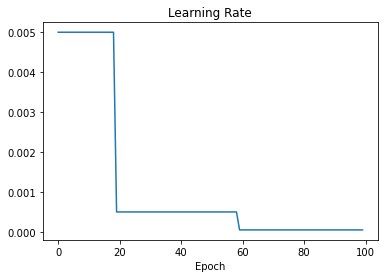

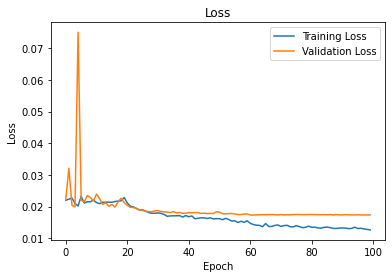

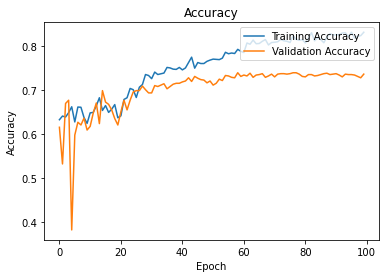

In [27]:
# visualization
# Learning Rate
plt.plot(range(epochs), Learning_rate_model2)
plt.title('Learning Rate')
plt.xlabel('Epoch')
plt.show()
# Loss
plt.plot(range(epochs), Loss_model2, label='Training Loss')
plt.plot(range(epochs), ValLoss_model2, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc = 'upper right')
plt.show()
# Accuracy
plt.plot(range(epochs), Acc_model2, label='Training Accuracy')
plt.plot(range(epochs),  ValAcc_model2, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc = 'upper right')
plt.show()

### observations
> 在learning rate decay中，可以使得在模型在訓練的過程中，在最一開始有較大的learning rate能讓loss快速下降，但在後面的過程，把learning rate降小，期待可以達到local minima或是global minima。另外藉由圖示，可以看到learning rate decay不管在accuarcy或是loss curve都有個圓弧曲線，並且所獲得的Accuracy相較於learning rate都為固定的模型來的高。

#### 2.5 Please calculate the confusion matrix and print the accuracy of two models with the test dataset. (10%)
##### (Example figure)
![image.png](https://github.com/tingyan08/Deep-Learning-and-Computer-Vision/blob/main/HW4/img/confusion%20matrix.png?raw=true)

In [34]:
# define 2 confusion matrix
confusion_matrix1 = torch.zeros(3, 3)
confusion_matrix2 = torch.zeros(3, 3)
model1 = CNN()
model1.load_state_dict(torch.load('./model_without_scheduler.pth'))
model2 = CNN()
model2.load_state_dict(torch.load('./model_with_scheduler.pth'))

<All keys matched successfully>

In [35]:
with torch.no_grad():
    model1.eval()
    model2.eval()
    
    for data, label in test_loader:
        data, label = Variable(data.to(device)), Variable(label.to(device))
        predict = model1(data)
        predict = predict.argmax(dim=1)
        for t, p in zip(label, predict):
            confusion_matrix1[t.item(), p.item()] += 1
        
        predict = model2(data)
        predict = predict.argmax(dim=1)
        for t, p in zip(label,predict):
            confusion_matrix2[t.item(), p.item()] += 1

print(confusion_matrix1,confusion_matrix2)

tensor([[12., 50.,  8.],
        [ 6., 53., 11.],
        [ 0.,  3., 67.]]) tensor([[52., 13.,  5.],
        [11., 54.,  5.],
        [ 2.,  2., 66.]])


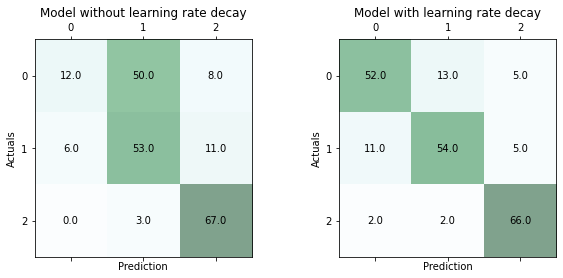

In [36]:
# plot the figure
fig, ax = plt.subplots(1,2, figsize=(10,4))
# confusion_matrix1
confusion_matrix1 = confusion_matrix1.cpu().numpy()
ax[0].matshow(confusion_matrix1, alpha=0.5, cmap=plt.cm.BuGn)
ax[0].set_title('Model without learning rate decay')
ax[0].set_xlabel('Prediction')
ax[0].set_ylabel('Actuals')

for row in range(confusion_matrix1.shape[0]):
    for column in range(confusion_matrix1.shape[1]):
        ax[0].text(column, row, confusion_matrix1[row,column], va='center', ha='center')
        
# confusion_matrix2
confusion_matrix2 = confusion_matrix2.cpu().numpy()
ax[1].matshow(confusion_matrix2, alpha=0.5, cmap=plt.cm.BuGn)
ax[1].set_title('Model with learning rate decay')
ax[1].set_xlabel('Prediction')
ax[1].set_ylabel('Actuals')

for row in range(confusion_matrix2.shape[0]):
    for column in range(confusion_matrix2.shape[1]):
        ax[1].text(column, row, confusion_matrix2[row,column], va='center', ha='center')

plt.show()
        

#### 2.6 Please choose the best model to predict the categories of images in the ***./animals/predict*** folder and show the figure with the prediction as title of each axes. (10%)
##### (Example figure)
![image.png](https://github.com/tingyan08/Deep-Learning-and-Computer-Vision/blob/main/HW4/img/img1.png?raw=true)

In [47]:
# create model
model_last = CNN()
model_last.load_state_dict(torch.load('./model_with_scheduler.pth'))
model_last.to(device)

names = glob.glob(os.path.join('./animals/prediction', '*.jpg'))
image = [Image.open(i) for i in names]
prediction_last = []
#class_list = ['cats', 'dogs', 'panda']
for count in image:
    data = test_dataset.transform(count)
    data = data.unsqueeze(0)
    with torch.no_grad():
        model_last.eval()
        data = data.to(device)
        #data = data(class_list).to(device)
        predict = model_last(data)
        predict = predict.argmax(dim=1)
        prediction_last.append(predict.item())

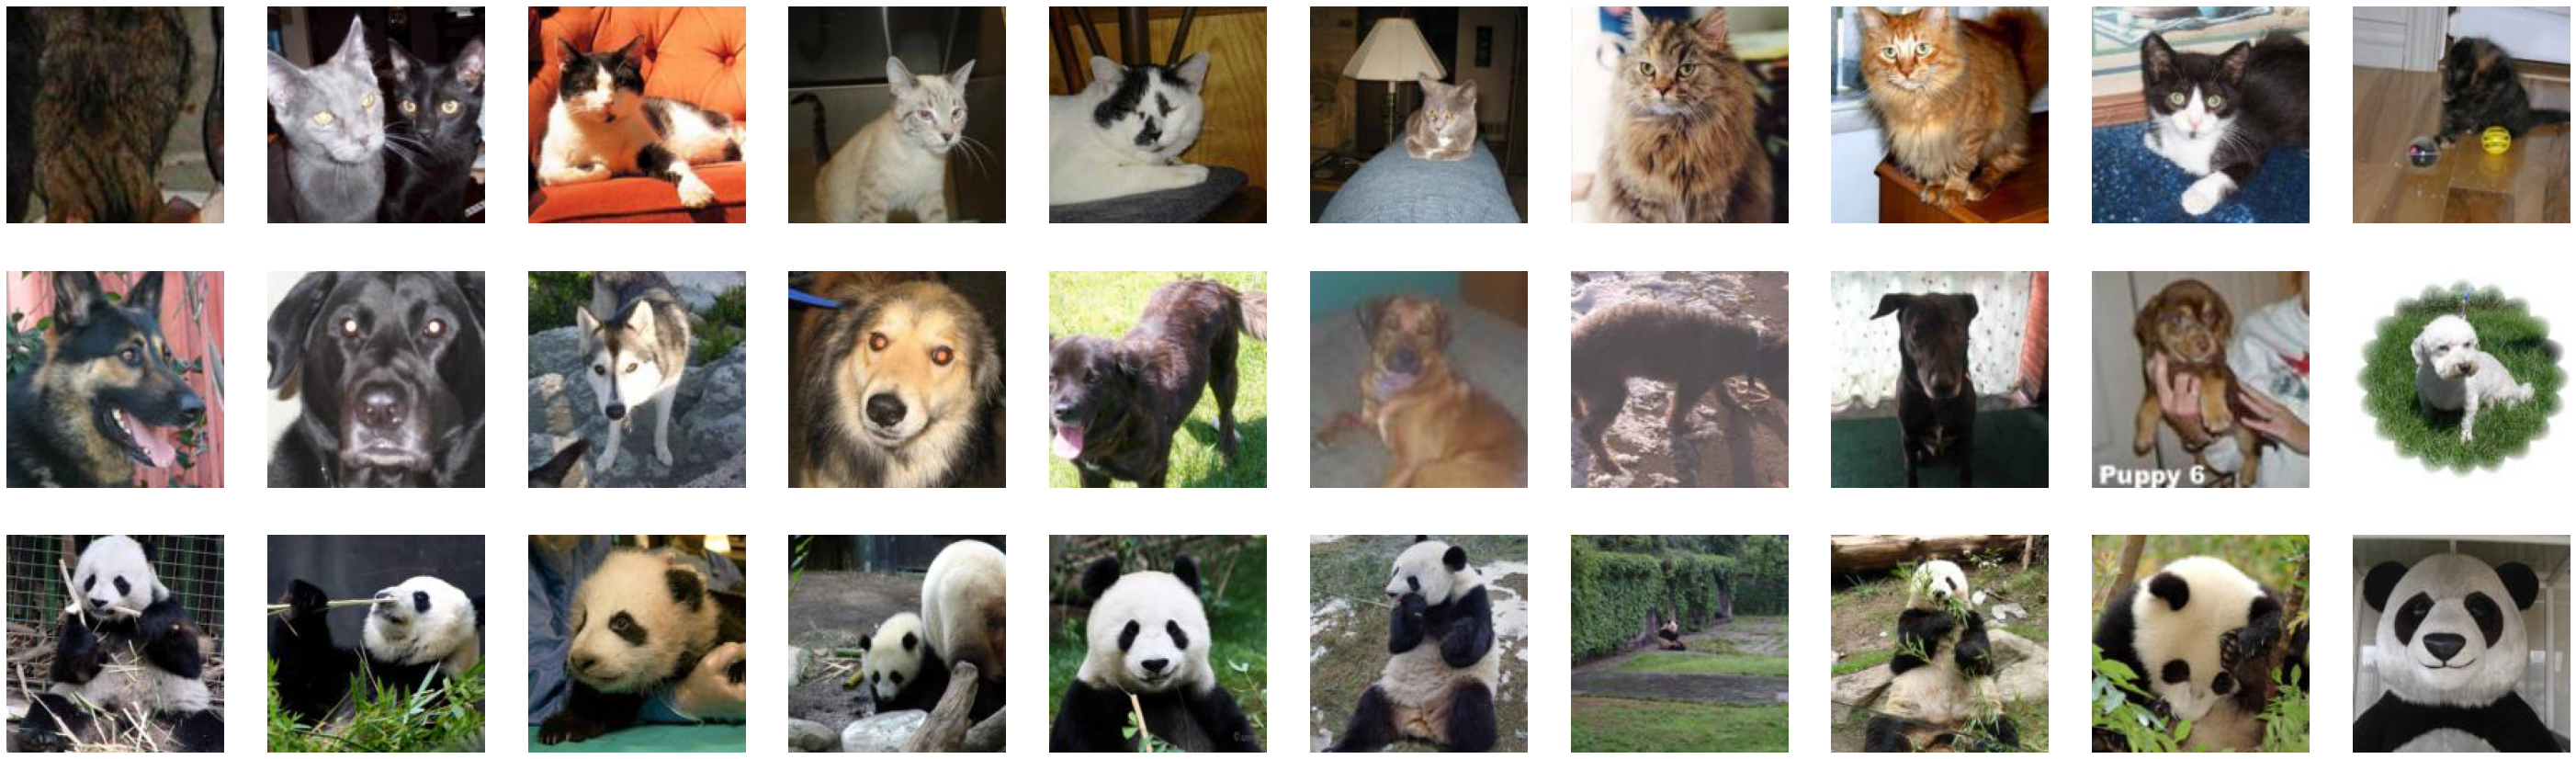

In [49]:
# plot the figure
fig, ax = plt.subplots(3,10, figsize=(50,15))
for i, (img, predict) in enumerate(zip(image, prediction_last)):
    ax[i//10][i%10].imshow(img)
    #ax[i//10][i%10].set_title()
    ax[i//10][i%10].axis('off')
plt.show()